# Use CPU

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn. metrics import confusion_matrix
import matplotlib.pyplot as plt

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data/', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data/', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=20, shuffle=True)
test_loader = DataLoader(test_data, batch_size=20, shuffle=False)

class ConvolutionalNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.log_softmax(self.fc3(X), dim=1)

        return X

model = ConvolutionalNetwork()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

import time
start_time = time.time()

# variables (trackers)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop epochs
for i in range(epochs):

    train_corr = 0
    test_corr = 0

    # train
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        # X_train = X_train
        # y_train = y_train
        y_pred = model(X_train)  # no need to flatten for CNN
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        train_corr += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%300 == 0:
            print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(train_corr)
    
    # test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            y_val = model(X_test)
            loss = criterion(y_val, y_test)

            predicted = torch.max(y_val.data, 1)[1]
            test_corr += (predicted == y_test).sum()

    test_losses.append(loss)
    test_correct.append(test_corr)
            
current_time = time.time()
total_time = current_time - start_time
print(f'Duration is {total_time/60} mins')

Epoch: 0 Batch: 300 Loss: 0.19923879206180573
Epoch: 0 Batch: 600 Loss: 0.3355424106121063
Epoch: 0 Batch: 900 Loss: 0.588188111782074
Epoch: 0 Batch: 1200 Loss: 0.4802677035331726
Epoch: 0 Batch: 1500 Loss: 0.05762867256999016
Epoch: 0 Batch: 1800 Loss: 0.04639798775315285
Epoch: 0 Batch: 2100 Loss: 0.04718516021966934
Epoch: 0 Batch: 2400 Loss: 0.12742990255355835
Epoch: 0 Batch: 2700 Loss: 0.008168680593371391
Epoch: 0 Batch: 3000 Loss: 0.05294569581747055
Epoch: 1 Batch: 300 Loss: 0.23256555199623108
Epoch: 1 Batch: 600 Loss: 0.15350341796875
Epoch: 1 Batch: 900 Loss: 0.3407380282878876
Epoch: 1 Batch: 1200 Loss: 0.052543383091688156
Epoch: 1 Batch: 1500 Loss: 0.012765685096383095
Epoch: 1 Batch: 1800 Loss: 0.010356596671044827
Epoch: 1 Batch: 2100 Loss: 0.009910034015774727
Epoch: 1 Batch: 2400 Loss: 0.16558624804019928
Epoch: 1 Batch: 2700 Loss: 0.04246605187654495
Epoch: 1 Batch: 3000 Loss: 0.0022849454544484615
Epoch: 2 Batch: 300 Loss: 0.036422014236450195
Epoch: 2 Batch: 600 

# Try to use GPU efficiently

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")                             # set the device to cuda

# Transform to tensor
transform = transforms.ToTensor()

# Load MNIST data
train_data = datasets.MNIST(root='../Data/', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data/', train=False, download=True, transform=transform)

# Loaders with pin_memory=True for faster data transfer to GPU
train_loader = DataLoader(train_data, batch_size=20, shuffle=True, pin_memory=True)                        # set the pin_memory=True
test_loader = DataLoader(test_data, batch_size=20, shuffle=False, pin_memory=True)

# Define CNN model
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.log_softmax(self.fc3(X), dim=1)
        return X

# Initialize model and move to device (GPU or CPU)
model = ConvolutionalNetwork().to(device)                                                            # model move to device CUDA

# Define loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)                                                       # loss move to device CUDA
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scaler = torch.amp.GradScaler()                                                                    # Set up mixed precision training

# Training parameters
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

start_time = time.time()

# Training loop
for i in range(epochs):
    train_corr = 0
    test_corr = 0

    # Training phase
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)                                          # X_train and y_train move to device CUDA
        
        # Forward pass with autocast for mixed precision
        with torch.amp.autocast(device_type='cuda'):
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        train_corr += (predicted == y_train).sum()

        optimizer.zero_grad()

        # Backward pass                                                                     # Set up mixed precision training scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if b % 300 == 0:
            print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

    train_losses.append(loss.item())
    train_correct.append(train_corr.item())

    # Testing phase (no gradient computation)
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)                                    # X_test and y_test move to device CUDA

            with torch.amp.autocast(device_type='cuda'):                                            # Set up cuda
                y_val = model(X_test)
                loss = criterion(y_val, y_test)

            predicted = torch.max(y_val.data, 1)[1]
            test_corr += (predicted == y_test).sum()

    test_losses.append(loss)
    test_correct.append(test_corr)

current_time = time.time()
total_time = current_time - start_time
print(f'Duration: {total_time/60:.2f} minutes')

Epoch: 0 Batch: 0 Loss: 2.278815746307373
Epoch: 0 Batch: 300 Loss: 0.6107416152954102
Epoch: 0 Batch: 600 Loss: 0.1221124529838562
Epoch: 0 Batch: 900 Loss: 0.18486669659614563
Epoch: 0 Batch: 1200 Loss: 0.03528972342610359
Epoch: 0 Batch: 1500 Loss: 0.1097133532166481
Epoch: 0 Batch: 1800 Loss: 0.11011260747909546
Epoch: 0 Batch: 2100 Loss: 0.4448215961456299
Epoch: 0 Batch: 2400 Loss: 0.1753503978252411
Epoch: 0 Batch: 2700 Loss: 0.013160218484699726
Epoch: 1 Batch: 0 Loss: 0.0018584579229354858
Epoch: 1 Batch: 300 Loss: 0.10041536390781403
Epoch: 1 Batch: 600 Loss: 0.21989528834819794
Epoch: 1 Batch: 900 Loss: 0.008303202688694
Epoch: 1 Batch: 1200 Loss: 0.0019848421216011047
Epoch: 1 Batch: 1500 Loss: 0.0009590493282303214
Epoch: 1 Batch: 1800 Loss: 0.007465729955583811
Epoch: 1 Batch: 2100 Loss: 0.014460556209087372
Epoch: 1 Batch: 2400 Loss: 0.046922389417886734
Epoch: 1 Batch: 2700 Loss: 0.17186346650123596
Epoch: 2 Batch: 0 Loss: 0.04753657802939415
Epoch: 2 Batch: 300 Loss: 0

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [5]:
transform = transforms.ToTensor()

In [98]:
train_data = datasets.MNIST(root='../Data/', train=True, download=True, transform=transform)

In [100]:
test_data = datasets.MNIST(root='../Data/', train=False, download=True, transform=transform)

In [11]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [13]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [102]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [17]:
# 1 color channel, 6 filter number of filters, 3 by 3 kernal
conv1 = nn.Conv2d(1, 6, 3, 1)

# output of conv1 has 6 channels (after using 6 filters in convolustion), 16 is the filter number will be used here, 3 is 3by3 kernal, 1 is stride
conv2 = nn.Conv2d(6, 16, 3, 1)

In [73]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [69]:
for i, (X_train, y_train) in enumerate(train_loader):
    break

In [75]:
X_train.shape

torch.Size([1, 28, 28])

In [31]:
X_train.view(1, 1, 28, 28)

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [33]:
x = X_train.view(1,1,28,28)

In [37]:
x = F.relu(conv1(x))

In [39]:
x.shape

torch.Size([1, 6, 26, 26])

In [41]:
x = F.max_pool2d(x, 2, 2)

In [43]:
x.shape

torch.Size([1, 6, 13, 13])

In [45]:
x = F.relu(conv2(x))

In [47]:
x.shape

torch.Size([1, 16, 11, 11])

In [49]:
x = F.max_pool2d(x, 2, 2)

In [51]:
x.shape

torch.Size([1, 16, 5, 5])

In [53]:
x.view(-1, 16*5*5).shape

torch.Size([1, 400])

In [104]:
class ConvolutionNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.log_softmax(self.fc3(X), dim=1)
        return X

In [106]:
model = ConvolutionNetwork()

In [108]:
model

ConvolutionNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [65]:
total_param = 0

for param in model.parameters():
    print(param.numel())
    total_param += param.numel()

print(f'\nTotal number of parameters is {total_param}')

54
6
864
16
48000
120
10080
84
840
10

Total number of parameters is 60074


In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [112]:
import time
start_time = time.time()

# variables (trackers)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop epochs
for i in range(epochs):
    train_corr = 0
    test_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        train_corr += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%600 == 0:
            print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(train_corr)

    # Test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            loss = criterion(y_val, y_test)

            predicted = torch.max(y_val.data, 1)[1]
            test_corr += (predicted == y_test).sum()
    
    
    test_losses.append(loss)
    test_correct.append(test_corr)

current_time = time.time()
total = current_time - start_time


Epoch: 0 Batch: 0 Loss: 2.3076930046081543
Epoch: 0 Batch: 600 Loss: 0.21185477077960968
Epoch: 0 Batch: 1200 Loss: 0.1516275703907013
Epoch: 0 Batch: 1800 Loss: 0.3111376166343689
Epoch: 0 Batch: 2400 Loss: 0.1199762225151062
Epoch: 0 Batch: 3000 Loss: 0.002210408914834261
Epoch: 0 Batch: 3600 Loss: 0.3595481216907501
Epoch: 0 Batch: 4200 Loss: 0.398948609828949
Epoch: 0 Batch: 4800 Loss: 0.209685280919075
Epoch: 0 Batch: 5400 Loss: 0.05413351580500603
Epoch: 1 Batch: 0 Loss: 0.08925237506628036
Epoch: 1 Batch: 600 Loss: 0.00016778442659415305
Epoch: 1 Batch: 1200 Loss: 0.002400202676653862
Epoch: 1 Batch: 1800 Loss: 0.002055941615253687
Epoch: 1 Batch: 2400 Loss: 0.0013374390546232462
Epoch: 1 Batch: 3000 Loss: 0.010751774534583092
Epoch: 1 Batch: 3600 Loss: 0.009403502568602562
Epoch: 1 Batch: 4200 Loss: 0.004251515027135611
Epoch: 1 Batch: 4800 Loss: 0.021249111741781235
Epoch: 1 Batch: 5400 Loss: 0.0002349248097743839
Epoch: 2 Batch: 0 Loss: 0.06728826463222504
Epoch: 2 Batch: 600

In [114]:
print(f'Total running duration is {total/60} mins')

Total running duration is 7.12779952287674 mins


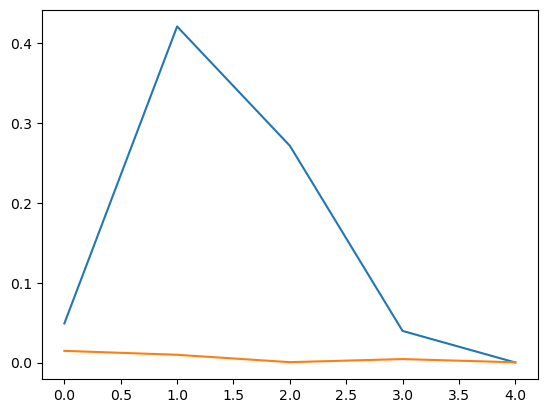

In [116]:
plt.plot([loss.item() for loss in train_losses])
plt.plot([loss.item() for loss in test_losses])

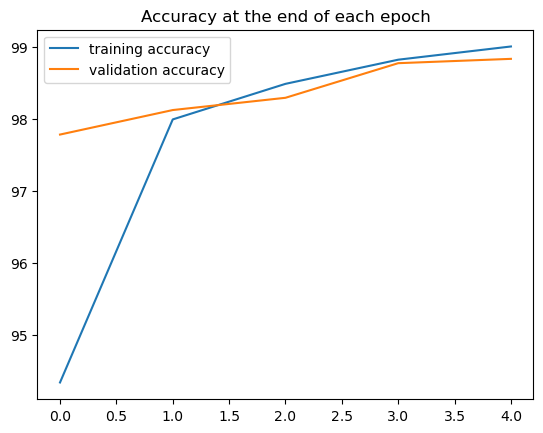

In [118]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [120]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [126]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()
accuracy = 100*correct.item()/10000
print(accuracy)

98.83


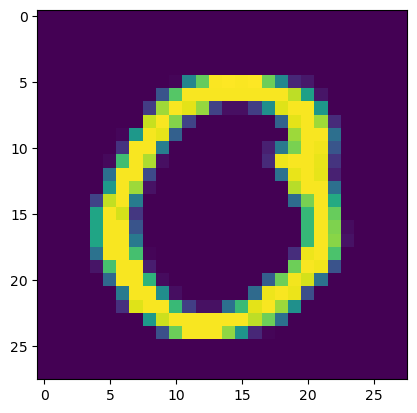

In [138]:
plt.imshow(test_data[1995][0].reshape(28,28))

In [142]:
model.eval()
with torch.no_grad():
    new_predication = model(test_data[1995][0].view(1, 1, 28,28))

In [154]:
torch.max(new_predication,1)[1]

tensor([0])

In [156]:
new_predication.argmax()

tensor(0)

## Test other details

In [8]:
# 1 color channel, 6 filters, 3 by 3 kernal, stride = 1
conv1 = nn.Conv2d(1, 6, 3, 1)

# 6 input filters Conv1, 16 filters (output channels), 3 by 3 kernal, stride = 1
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [10]:
X_train.shape

torch.Size([1, 28, 28])

In [11]:
y_train

5

In [12]:
x = X_train.view(1, 1, 28, 28)  # --> 4D batch (batch of 1 image)

In [13]:
x = F.relu(conv1(x))

In [14]:
# 1 means 1 single image, 6 is the filter number, 26 = ((28 + 0 (padding) - 3 (kernal size))/stride) + 1

x.shape

torch.Size([1, 6, 26, 26])

In [15]:
x = F.max_pool2d(x, 2, 2)

In [16]:
# 26 is height of previous conv1 result, the first 2 is kernal size, the second 2 is the stride size, the 1 is a constant value.
# width/height 13 = ((26-2)/2) + 1

x.shape

torch.Size([1, 6, 13, 13])

In [17]:
x = F.relu(conv2(x))

In [18]:
# width/height 11 = ((13-3)/1) + 1

x.shape

torch.Size([1, 16, 11, 11])

In [19]:
x = F.max_pool2d(x, 2, 2)

In [20]:
# width/height 5 = ((11-2)/2) + 1 = 4 + 1

x.shape

torch.Size([1, 16, 5, 5])

In [21]:
x.view(-1, 16*5*5).shape

torch.Size([1, 400])

In [24]:
torch.cuda.is_available()

True

In [25]:
torch.cuda.current_device()

0

In [26]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 4060 Laptop GPU'

In [27]:
# 3*3*1*6 (total filter parameters) + 6 (bias) + 3*3*6*16 (total filter parameters) + 16 (bias) 
# + 400 * 120 (total weight parameters) + 120 (bias) + 120 * 84 (total weight parameters) + 84 (bias) + 84 * 10 (total weight parameters) + 10 (bias)

params = 0

for param in model.parameters():
    print(param.numel())
    params += param.numel()

print(f'\nTotal number of parameters is {params}')

54
6
864
16
48000
120
10080
84
840
10

Total number of parameters is 60074
